# Макет обнаружения аномальных HTTP-запросов к веб-серверу с помощью рекуррентного seq2seq автоэнкодера

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import random
from pickle import dump
from utils import get_requests_from_file, strlist_to_ohearray
import colorama
from colorama import Back
from matplotlib import pyplot as plt
colorama.init(autoreset=True, strip=False)
random.seed(57)

## Задание глобальных параметров

In [2]:
# setting params
batch_size = 128  # Batch size for training.
epochs = 40       # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

## Загрузка и подготовка данных

In [4]:
# loading data from text file
normal_requests = get_requests_from_file('train.txt')
anomal_requests = get_requests_from_file('anomaly.txt')
valid_requests = [normal_requests.pop(random.randint(0, len(normal_requests)))
                  for i in range(len(anomal_requests))]


# creating token index
tokens = set()
for request in normal_requests:
    for char in request:
        if char not in tokens:
            tokens.add(char)

tokens = sorted(list(tokens))
tokens += ['<PAD>', '<UNK>', '<GO>', '<EOR>']

num_tokens = len(tokens)
max_normal_seq_length = max([len(request) for request in normal_requests])

token_index = dict([(token, i) for i, token in enumerate(tokens)])
reverse_token_index = dict((i, token) for token, i in token_index.items())

# saving token index and data
with open('token_index', 'wb') as f:
    dump(token_index, f)
with open('normal_requests', 'wb') as f:
    dump(normal_requests, f)
with open('anomal_requests', 'wb') as f:
    dump(anomal_requests, f)
with open('valid_requests', 'wb') as f:
    dump(valid_requests, f)

print("Number of train samples:", len(normal_requests))
print("Number of validation samples:", len(valid_requests))
print("Number of anomal samples:", len(anomal_requests))
print("Number of unique vocabulary tokens:", num_tokens)
print("Max train request length:", max_normal_seq_length)

Number of train samples: 20894
Number of validation samples: 1097
Number of anomal samples: 1097
Number of unique vocabulary tokens: 87
Max train request length: 2011


## Оцифровка обучающих, валидационных и тестовых (аномальных) запросов

In [6]:
# creating train, valid and anomal data in form of 3d-ohe-arrays for autoencoder
encoder_train_input_data = strlist_to_ohearray(normal_requests, max_normal_seq_length,
                                         token_index, decoder = False, target = False)
 
decoder_train_input_data = strlist_to_ohearray(normal_requests, max_normal_seq_length,
                                         token_index, decoder = True, target = False)

decoder_train_target_data = strlist_to_ohearray(normal_requests, max_normal_seq_length,
                                                token_index, decoder = True, target = True)

encoder_valid_input_data = strlist_to_ohearray(valid_requests, max_normal_seq_length,
                                         token_index, decoder = False, target = False)
 
decoder_valid_input_data = strlist_to_ohearray(valid_requests, max_normal_seq_length,
                                         token_index, decoder = True, target = False)

decoder_valid_target_data = strlist_to_ohearray(valid_requests, max_normal_seq_length,
                                                token_index, decoder = True, target = True)

encoder_anomal_input_data = strlist_to_ohearray(anomal_requests, max_normal_seq_length,
                                         token_index, decoder = False, target = False)
 
decoder_anomal_input_data = strlist_to_ohearray(anomal_requests, max_normal_seq_length,
                                         token_index, decoder = True, target = False)

decoder_anomal_target_data = strlist_to_ohearray(anomal_requests, max_normal_seq_length,
                                                 token_index, decoder = True, target = True)

# Этап создания и обучения модели можно пропустить, если модель уже обучена и сохранена
## Обучение занимает время, можно перейти сразу к ячейке "Загрузка модели с диска"

## Создание модели Seq2seq-автокодировщика

In [7]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard 'encoder_outputs' and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder## Задание глобальных параметров, using 'encoder_states' as initial state.
decoder_inputs = keras.Input(shape=(None, num_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# 'encoder_train_input_data' & 'decoder_train_input_data' into 'decoder_train_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

## Обучение модели

In [8]:
model.fit(
    [encoder_train_input_data, decoder_train_input_data],
    decoder_train_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data = ([encoder_valid_input_data, decoder_valid_input_data], decoder_valid_target_data),
    verbose=2
)

Epoch 1/40
164/164 - 82s - loss: 1.5709 - accuracy: 0.6567 - val_loss: 1.4855 - val_accuracy: 0.6940
Epoch 2/40
164/164 - 78s - loss: 0.8612 - accuracy: 0.7582 - val_loss: 0.5688 - val_accuracy: 0.8554
Epoch 3/40
164/164 - 81s - loss: 0.3841 - accuracy: 0.9103 - val_loss: 0.2593 - val_accuracy: 0.9403
Epoch 4/40
164/164 - 78s - loss: 0.1656 - accuracy: 0.9630 - val_loss: 0.1168 - val_accuracy: 0.9718
Epoch 5/40
164/164 - 79s - loss: 0.0909 - accuracy: 0.9768 - val_loss: 0.0711 - val_accuracy: 0.9813
Epoch 6/40
164/164 - 79s - loss: 0.0590 - accuracy: 0.9853 - val_loss: 0.0453 - val_accuracy: 0.9904
Epoch 7/40
164/164 - 79s - loss: 0.0401 - accuracy: 0.9906 - val_loss: 0.0412 - val_accuracy: 0.9901
Epoch 8/40
164/164 - 80s - loss: 0.0312 - accuracy: 0.9925 - val_loss: 0.0275 - val_accuracy: 0.9931
Epoch 9/40
164/164 - 78s - loss: 0.0265 - accuracy: 0.9934 - val_loss: 0.0243 - val_accuracy: 0.9938
Epoch 10/40
164/164 - 78s - loss: 0.0232 - accuracy: 0.9940 - val_loss: 0.0210 - val_accura

## Сохранение модели и оценка работы 

In [10]:
# Save model
model.save("model")

# Evaluate model
model.evaluate([encoder_train_input_data, decoder_train_input_data], decoder_train_target_data, verbose=2)

model.evaluate([encoder_valid_input_data, decoder_valid_input_data], decoder_valid_target_data, verbose=2)

model.evaluate([encoder_anomal_input_data, decoder_anomal_input_data], decoder_anomal_target_data, verbose=2)

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


653/653 - 67s - loss: 0.0136 - accuracy: 0.9953
35/35 - 3s - loss: 0.0141 - accuracy: 0.9951
35/35 - 4s - loss: 0.8535 - accuracy: 0.8938


[0.8534749150276184, 0.8937879204750061]

## Загрузка модели с диска

In [12]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("model")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name = 'decoder_state_input_h')
decoder_state_input_c = keras.Input(shape=(latent_dim,), name = 'decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

## Определение функций для обработки моделью одного "сырого" запроса и определения ошибки реконструкции и вероятностей для каждого символа

In [21]:
# define functions that process one raw request by AE into it's reproduction error and
# probabilities for each character

def decode_sequence(dec_input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(dec_input_seq[:,1:-1,:])

    # Populate the first character of target sequence with the start character.
    target_seq = dec_input_seq[:,0:1,:]

    # Sampling loop for a batch of sequences
    decoded = np.zeros(dec_input_seq[:,1:-1,:].shape)
    for i in range(dec_input_seq[:,1:-1,:].shape[1]):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        decoded[:,i:i+1,:] = output_tokens
        target_seq = dec_input_seq[:,i+1:i+2,:]
        states_value = [h, c]
    return decoded

def process_request(request):
    req_emb = strlist_to_ohearray([request], len(request), token_index,
                                  decoder = True, target=False)
    req_decoded = decode_sequence(req_emb)
    req_emb = req_emb[:,1:-1,:]
    req_emb = req_emb.reshape((req_emb.shape[1],req_emb.shape[2]))
    req_decoded = req_decoded.reshape((req_decoded.shape[1],req_decoded.shape[2]))
    
    req_indexes = []
    for i in range(req_emb.shape[0]):
        req_indexes += [np.argmax(req_emb[i,:])]
    
    decoded_probs = []
    for i in range(req_decoded.shape[0]):
        decoded_probs += [req_decoded[i,req_indexes[i]]]
    
    decoded_probs = np.array(decoded_probs)
    
    error = 1 - np.mean(decoded_probs)
    
    return decoded_probs, error

def visual(request, probs):
    for i, char in enumerate(request):
        if probs[i]<0.5:
            print(Back.RED + char, end = "")
        else:
            print(Back.RESET + char, end = "")

## Обработка моделью валидационных (нормальных) и тестовых (аномальных) запросов
Занимает значительное время (порядка нескольких часов, лучше ставить на ночь)

In [16]:
valid_error = []
valid_probs = []
for n, request in enumerate(valid_requests):
    print('\rProcessing validation sample {:d}/{:d}'.format(n+1, len(valid_requests)), end='')
    decoded_probs, error = process_request(request)
    valid_probs.append(decoded_probs)
    valid_error.append(error)
print()
    
anomal_error = []
anomal_probs = []
for n, request in enumerate(anomal_requests):
    print('\rProcessing anomal sample {:d}/{:d}'.format(n+1, len(anomal_requests)), end='')
    decoded_probs, error = process_request(request)
    anomal_probs.append(decoded_probs)
    anomal_error.append(error)
print()

Processing validation sample 1097/1097
Processing anomal sample 1097/1097

## Сохранение результатов обработки

In [17]:
with open('valid_error', 'wb') as f:
    dump(valid_error, f)
with open('valid_probs', 'wb') as f:
    dump(valid_probs, f)
with open('anomal_error', 'wb') as f:
    dump(anomal_error, f)
with open('anomal_probs', 'wb') as f:
    dump(anomal_probs, f)

## Определение порогового значения ошибки для обнаружения аномалий

In [24]:
K_sigma = 6
threshold = np.mean(valid_error) + K_sigma * np.std(valid_error)
with open('model/threshold', 'wb') as f:
    dump(threshold, f)## Загрузка модели с диска
print(threshold)

0.11616830066345976


## Построение гистограммы для нормальных и аномальных запросов

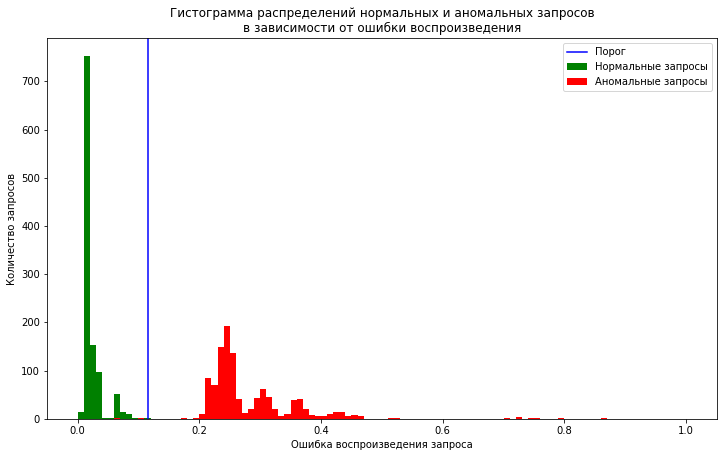

In [26]:
# plot histograms of valid and anomal requests by it's reproduction error
bins = np.linspace(0,1,101)

plt.figure(figsize=(12,7))
plt.hist(valid_error, bins, label='Нормальные запросы', color = 'green')
plt.hist(anomal_error, bins, label='Аномальные запросы', color = 'red')
plt.axvline(threshold, label='Порог', color='blue')
plt.legend(loc='upper right')
plt.xlabel('Ошибка воспроизведения запроса')
plt.ylabel('Количество запросов')
plt.title('Гистограмма распределений нормальных и аномальных запросов\nв зависимости от ошибки воспроизведения')
plt.savefig('Histogram.png')
plt.show()

## Вычисление метрик качества для, вывод отчета и сохранение в файл

In [20]:
# calculating quality metrics

FN_ind = np.where(np.array(anomal_error)<=threshold)[0].tolist()
FP_ind = np.where(np.array(valid_error)>threshold)[0].tolist()
TN_ind = np.where(np.array(valid_error)<=threshold)[0].tolist()
TP_ind = np.where(np.array(anomal_error)>threshold)[0].tolist()

FN, FP, TN, TP = len(FN_ind), len(FP_ind), len(TN_ind), len(TP_ind)
accuracy_score = (TP + TN) / (TP + TN + FP + FN)
precision_score = TP / (TP + FP)
recall_score = TP / (TP + FN)
f1_score = 2 * precision_score * recall_score / (precision_score + recall_score)
conf_matrix = pd.DataFrame(
    [[TP, FN], [FP, TN]], 
    index=['true:anomal', 'true:normal'], 
    columns=['pred:anomal', 'pred:normal']
    )

print()
print('Test report:')
print('____________')
print('Accuracy score  :', accuracy_score)
print('Precision score :', precision_score)
print('Recall score    :', recall_score)
print('F1 score        :', f1_score)
print()
print('Confusion matrix:')
print(conf_matrix)

with open('test report.txt', 'w') as f:
    print('Test report:', file = f)
    print('____________', file = f)
    print('Accuracy score  :', accuracy_score, file = f)
    print('Precision score :', precision_score, file = f)
    print('Recall score    :', recall_score, file = f)
    print('F1 score        :', f1_score, file = f)
    print('', file = f)
    print('Confusion matrix:', file = f)
    print(conf_matrix, file = f)


Test report:
____________
Accuracy score  : 0.9990884229717412
Precision score : 1.0
Recall score    : 0.9981768459434822
F1 score        : 0.9990875912408759

Confusion matrix:
             pred:anomal  pred:normal
true:anomal         1095            2
true:normal            0         1097


## Вывод всех FN- и FP-срабатываний, и нескольких TP-срабатываний с выделением участков аномальности запросов

In [29]:
# printing and visualize FN and FP samples
print()
for n in FN_ind:
    print('==== FN Anomal sample {}. Error: {} ====\n'.format(n,anomal_error[n]))
    visual(anomal_requests[n],  anomal_probs[n])
    print('\n\n')

for n in FP_ind:
    print('==== FP Valid sample {}. Error: {} ====\n'.format(n,valid_error[n]))
    visual(valid_requests[n],  valid_probs[n])
    print('\n\n')

# printing and visualize some TP samples 

for n in random.sample(TP_ind, 5):
    print('==== TP Anomal sample {}. Error: {} ====\n'.format(n,anomal_error[n]))
    visual(anomal_requests[n],  anomal_probs[n])
    print('\n\n')


==== FN Anomal sample 2. Error: 0.06589613067880684 ====

POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 Firefox/59.0
Accept: application/json, text/javascript, */*; q=0.01
Accept-Language: en-US,en;q=0.5
Accept-Encoding: gzip, deflate
Referer: http://10.0.212.25/vulnbank/online/transactions.php
Content-Type: application/x-www-form-urlencoded; charset=UTF-8
X-Requested-With: XMLHttpRequest
Content-Length: 162
Cookie: PHPSESSID=ch1upt4lk9onm6e26lo4lkc893
Connection: keep-alive

type=transaction&action=send&sender=DE00000111112222233333&recipient=DE11111656567474783838&creditcard=1234-6579-3514-6475&amount=2&comment=<svg onload=alert(1)>


==== FN Anomal sample 1044. Error: 0.1004049601073208 ====

GET /vulnbank/online/userinfo.php HTTP/1.1
Host: 10.0.212.25
Connection: close


==== TP Anomal sample 63. Error: 0.2536321723990459 ====

POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
Connection: